In [5]:
import pandas as pd
from pandas_profiling import ProfileReport
import sys
!pip install matplotlib
!pip install graphviz

<ipython-input-5-0e96e7604878>:2: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


In [135]:
data = pd.read_csv(r'C:\Users\Never\Downloads\Customer-Churn-Records.csv')
for col in data.columns:
  if data[col].dtype=='object':
    #making sure data is not read as bytes but as string values from a file
    data[col] = data[col].str.decode('utf-8')

Getting report of data info by pandas profiling

In [7]:
profile = data.profile_report()
profile.to_file(r'C:\Users\Never\Downloads\profile_report.html')



Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [71]:
summary=data.describe()
print(summary)

         RowNumber    CustomerId  Surname   CreditScore  Geography  Gender  \
count  10000.00000  1.000000e+04      0.0  10000.000000        0.0     0.0   
mean    5000.50000  1.569094e+07      NaN    650.528800        NaN     NaN   
std     2886.89568  7.193619e+04      NaN     96.653299        NaN     NaN   
min        1.00000  1.556570e+07      NaN    350.000000        NaN     NaN   
25%     2500.75000  1.562853e+07      NaN    584.000000        NaN     NaN   
50%     5000.50000  1.569074e+07      NaN    652.000000        NaN     NaN   
75%     7500.25000  1.575323e+07      NaN    718.000000        NaN     NaN   
max    10000.00000  1.581569e+07      NaN    850.000000        NaN     NaN   

                Age        Tenure        Balance  NumOfProducts    HasCrCard  \
count  10000.000000  10000.000000   10000.000000   10000.000000  10000.00000   
mean      38.921800      5.012800   76485.889288       1.530200      0.70550   
std       10.487806      2.892174   62397.405202       0.

In [136]:
#drop variable
data=data.drop(columns=['RowNumber'])
data=data.drop(columns=['CustomerId'])
data=data.drop(columns=['Surname'])

In [137]:
#create a list for categorical columns
cat_cols=["Geography","Gender","Card Type"]

In [138]:
#create a copy of data frame
df_onehot=data.copy()
#conver categorical variable to dummy
df_onehot=pd.get_dummies(data, columns=cat_cols, prefix=cat_cols)
#print dataset
df_onehot
import numpy as np
print(" \nCount total NaN in a DataFrame : \n\n",
       df_onehot.isnull().sum().sum())


 
Count total NaN in a DataFrame : 

 0


In [139]:
#Check for multicollinearity
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
x=df_onehot.values
vif=pd.DataFrame()
vif["variable"]=df_onehot.columns
vif["vif"]=[variance_inflation_factor(x,i) for i in range(x.shape[1])]
print(vif)

              variable         vif
0          CreditScore   24.042188
1                  Age   14.005189
2               Tenure    3.886539
3              Balance    2.674241
4        NumOfProducts    7.816895
5            HasCrCard    3.298865
6       IsActiveMember    2.152632
7      EstimatedSalary    3.901044
8               Exited  146.517378
9             Complain  146.361770
10  Satisfaction Score    5.279329
11        Point Earned    7.542687


VIF is to check the correlation between the independable variables. I'll remove all the variable, Complain with the highest VIF as there is high correlation. The reason for not removing all the variable with vif more than 10 is the R-squre for the multi-linear regression is too low, 0.037. Keeping those two variables， CreditScore and Age, can make the model more precise.

In [140]:
#remove high VIF variables.
df_onehot=df_onehot.drop(columns=['Complain'])



In [141]:
#train test set split
from sklearn.model_selection import train_test_split
class_col_name="Exited"
one_hot_feature_names=df_onehot.columns[df_onehot.columns !=class_col_name]
#split dataset into training set and test set
x_train, x_test, y_train, y_test = train_test_split(df_onehot.loc[:,  one_hot_feature_names], df_onehot[class_col_name], test_size=0.3, random_state=45)

Split the training set for 70% of the dataset,and 30% for the test set

Decision Tree

class Names ['1' '0']


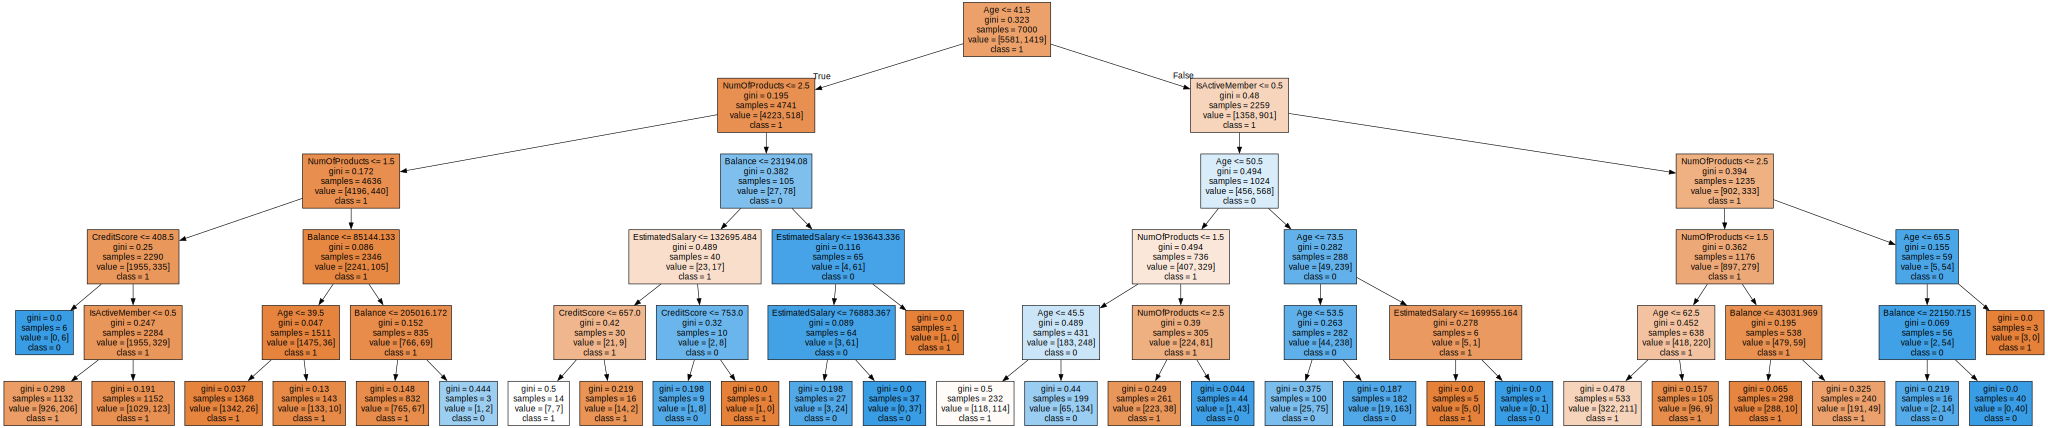

In [142]:
# Perform prediction on the test set
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(x_train, y_train)
import graphviz
y_pred = clf.predict(x_test)
#Get unique class values to display on the tree
class_values=df_onehot[class_col_name].unique()
class_values= class_values.astype(str)
print ("class Names",class_values)

dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=one_hot_feature_names,  
                                class_names=class_values,
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png")
graph

In [143]:
# Get classification report
from sklearn.metrics import classification_report
from sklearn import metrics

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.86      0.98      0.92      2381
           1       0.83      0.39      0.53       619

    accuracy                           0.86      3000
   macro avg       0.84      0.68      0.72      3000
weighted avg       0.85      0.86      0.84      3000



I choose weighted average here for the explaination as there is imbalance in the classes and class 1 has less support. The weighted average precision is 0.85, meaning that the there is a low rate of false positive. The recall is 0.86, indicating there is low rate of false negatives. And the accuracy is 0.84.

Linear Regression

In [144]:
#remove outliers
import numpy as np
z_scores=np.abs((df_onehot-df_onehot.mean())/df_onehot.std())
threshold=3.0
outliers=df_onehot[z_scores>threshold]
df_onehot_no_outliers= df_onehot[z_scores<= threshold]

In [145]:
#normalization
numeric_cols =['CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary','Point Earned']
df_onehot_no_outliers[numeric_cols] = (df_onehot_no_outliers[numeric_cols] - df_onehot_no_outliers[numeric_cols].min()) / (df_onehot_no_outliers[numeric_cols].max() - df_onehot_no_outliers[numeric_cols].min())
bank_data=df_onehot_no_outliers.copy()

In [146]:
#remove NAs
import numpy as np
print(" \nCount total NaN in a DataFrame : \n\n",
       bank_data.isnull().sum().sum())
bank_data=bank_data.dropna()
bank_data=bank_data.dropna(axis=1)

 
Count total NaN in a DataFrame : 

 201


In [147]:
#train test set split
from sklearn.model_selection import train_test_split
class_col_name="Exited"
one_hot_feature_names=df_onehot.columns[df_onehot.columns !=class_col_name]
#split dataset into training set and test set
X_train, X_test, Y_train, Y_test = train_test_split(df_onehot.loc[:,  one_hot_feature_names], df_onehot[class_col_name], test_size=0.3, random_state=90)

In [148]:
#linear regression
from sklearn.linear_model import LinearRegression
lr_model=LinearRegression()
lr_model.fit(X_train,Y_train)
lr_pred=lr_model.predict(X_test)
print("Intercept:", lr_model.intercept_)
print("Coefficients:", lr_model.coef_)
print("R-squared:", lr_model.score(X_train, Y_train))

Intercept: -0.10184154283790631
Coefficients: [-1.22111242e-04  1.13315580e-02 -1.12740348e-03  6.10127897e-07
 -1.35118120e-02  2.59375044e-04 -1.42693079e-01  7.90715112e-08
 -2.65075198e-03 -3.97777822e-06]
R-squared: 0.1236491191831488


R-squared is 0.12

KNN alogarithm

In [119]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, Y_train)
knn_pred = knn_model.predict(X_test)
print("Number of neighbors:", knn_model.n_neighbors)
print("Weights:", knn_model.weights)

Number of neighbors: 5
Weights: uniform


In [99]:
from sklearn.metrics import confusion_matrix
knn_cm = confusion_matrix(Y_test, knn_pred)
print("Confusion Matrix (KNN):\n", knn_cm)

Confusion Matrix (KNN):
 [[2230  159]
 [ 554   57]]


In [101]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
knn_acc = accuracy_score(Y_test, knn_pred)
knn_prec = precision_score(Y_test, knn_pred,average='weighted')
knn_rec = recall_score(Y_test, knn_pred,average='weighted')
print(f"Test Accuracy (KNN): {knn_acc:.3f}")
print(f"Precision(KNN): {knn_prec:.3f}")
print(f"Recall(KNN): {knn_rec:.3f}")


Test Accuracy (KNN): 0.762
Precision(KNN): 0.692
Recall(KNN): 0.762


In [149]:
# Cross Validation
rom sklearn.model_selection import cross_val_score, KFold
k=5
kf=KFold(n_splits=k, shuffle=True, random_state=42)
scores=cross_val_score(knn_model, X_train,Y_train, cv=kf, scoring='neg_mean_squared_error')
mse_scores= -scores
mean_mse=np.mean(mse_scores)
print("Mean Squared Error:", mean_mse)

Mean Squared Error: 0.23814285714285713


The MSR measures the average squared difference between the predicted value and the actual value. The MSE is 0.238, which means the model has a good performance.